## Astro 304 "Galaxies"

## Overview of galaxy properties

The experiments below use python (within IPython notebook environment), which will be used throughout this class. You should have one of the most commonly used python distributions - <a href="https://www.enthought.com/products/canopy/">Enthought Canopy</a> or <a href="https://www.continuum.io/downloads">Anaconda</a> -  installed on your laptop. Both are free for academic users. Don't be confused at Enthought site: you can request a free Enthought academic license <a href="https://store.enthought.com/#canopy-academic">here</a>, which will allow you to get distribution with many add-ons and libraries, such as their proprietory 3d visualization library <tt>Mayavi</tt>. Both Enthought and Anaconda will provide similar capabilities, although the way you interact with packages is somewhat different. Anaconda will come with most packages you need pre-installed, while in Enthought you will need to install some additional packages (which is easy). 

In a given python distro, you can launch IPython notebook by loading a notebook file or starting a new notebook using IDE editor (specific to each distro) or via command line: <tt>ipython notebook notebook_name.ipynb</tt>, which will open the notebook in a browser where it can be edited and executed.  

The rationale for using Notebooks can be found <a href="http://pgbovine.net/ipython-notebook-first-impressions.htm">here</a> - it simplifies work flow and closely connects plots that we will be discussing with the code that produces them. You can use these codes as a starting point for your own experimentation with data or calculations. 

To run examples presented here, you will need to install in addition to python (with standard libraries: matplotlib, numpy, scipy, etc. that come standard with each distribution), the following packages: 

<tt>pyfits</tt> - package for reading FITS files. The FITS file with the SDSS data that is used below is available here. 

<tt><a href="http://scikit-learn.org/stable/">scikit-learn</a></tt> - python package containing various useful machine learning routines, which we will be using from time to time. The routines are also used by the AstroML package.

<tt><a href="https://pypi.python.org/pypi/astroML/">AstroML</a></tt> - this library was developed to support the book <a href="http://press.princeton.edu/titles/10159.html"><i>''Statistics, Data Mining, and Machine Learning in Astronomy''</i></a> by Ivezic et al. The book itself is not needed for this course, although I will draw on it in parts of the course. It is very good though and I highly recommend to get and study it. 

<a href="https://bitbucket.org/bdiemer/colossus/overview"><tt>colossus</tt></a> - Benedikt Diemer's  python package containing useful routines for computing various cosmological quantities (distances, variances, power spectra, halo profiles, etc.) that we will be using throughout this course)

We may also need other packages that will be introduced during the course. 

### SDSS DR8 galaxy sample

For many exercises here and subsequent lectures we will be using SDSS data. The binary FITS file used in the explorations below can be downloaded <a href="http://astro.uchicago.edu/~andrey/classes/a304s15/data/sdss_dr8/SDSSspecgalsDR8.fit">here</a> (it is 165 Mb). It was produced at the SDSS <a href="http://skyserver.sdss.org/CasJobs/">CasJobs server</a> where time-intensive SQL queries can be submitted. The FITS file used below is large because it includes a number of properties that will be useful in our explorations and because it selects almost all low-z galaxies from the SDSS (called the main galaxy sample, to differentiate from the quasar and LRG samples). 

The SQL script used to produce the FITS file below can be found <a href="http://astro.uchicago.edu/~andrey/classes/a304s15/data/sdss_dr8/README.txt">here.</a> Description of various entries for SDSS objects classified as GALAXY in DR8 can be found <a href=http://skyserver.sdss.org/dr8/en/help/browser/browser.asp?n=Galaxy&t=U>here</a>, for STAR objects see <a href=http://skyserver.sdss.org/dr8/en/help/browser/description.asp?n=Star&t=V>here</a>. If you have not queried SDSS data base yet, I encourage you to use this example, to create CasJobs account and construct your own queries for particular properties. 

### Galaxies in the SDSS main sample

In [60]:
# setup notebook for inline figures
%matplotlib inline

from code.plot_utils import plot_pretty
plot_pretty()

The code for reading SDSS fits file can be found in code/read_sdss_fits; uncomment the following line, if you want to see the code inline here in the notebook. 

In [ ]:
#%load code/read_sdss_fits.py

In [ ]:
# routine data_home_dir in code/setup/setup.py should return top directory for data files

In [ ]:
from code.read_sdss_fits import read_sdss_fits
from code.setup import data_home_dir

# read fits file with the SDSS DR8 main spectroscopic sample
data = read_sdss_fits(data_home_dir()+'SDSSspecgalsDR8full.fit')


Now we apply some cuts to create well-defined magnitude limited sample and compute some useful quantities such as Vmax of galaxies. We then select a sample of the closest and brightest galaxies for closer examination. To compute cosmological distances we will use Benedikt Diemer's <a href="https://bitbucket.org/bdiemer/colossus/overview">colossus python package</a> (we will also use other useful routines from colossus in other parts of this course)

In [ ]:
import numpy as np

# lower limit on z is to avoid the nearest galaxies for which SDSS pipeline often does not perform well (splitting them into pieces, etc)
# with z_min=0.005 we are excluding galaxies closer than the Virgo cluster
# z_max=1.0 is to avoid misclassified objects that appear as very high z systems
z_min = 0.005; z_max = 1.0

# SDSS DR8 solid angle, see:
# https://www.sdss3.org/dr8/scope.php
solid_angle = 9274.*(np.pi/180)**2

# magnitude cuts appropriate for the SDSS main spectroscopic sample 
m_min = 14.0; m_max = 17.77
# correct r-band Petrosian magnitudes for Galactic extinction before applying magnitude cuts
mr = data['petroMag_r'] - data['extinction_r']
gr = data['cmodelMag_g'] - data['cmodelMag_r']
# redshift cut and magnitude cuts
data = data[(data['z'] > z_min) & (data['z'] < z_max) & (mr > m_min) & (mr < m_max) & (gr>-0.5) & (gr<2.5)]

# first let's compute some things for the entire z- and magnitude limited sample
# g-r color in model mags
gr = data['cmodelMag_g'] - data['cmodelMag_r']
mcmodel = data['cmodelMag_r']
r50 = data['petroR50_r']; z = data['z']; ext = data['extinction_r']
# extinction-corrected surface brightness using Petrosian magnitude and half-light radius
mpetro = data['petroMag_r'] - ext
sb = mpetro - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(r50)**2)

print "selected %d galaxies"%np.shape(sb)
# now compute distances and maximum comoving volume out to which galaxy would be detectable
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

# compute luminosity and angular distances
d_L = cosmo.luminosityDistance(z)/cosmo.h
d_A = d_L/(1.+z)**2

# absolute magnitude in the r-band; apply +1.3*z correction for evolution (see Bernardi et al. 2010)
# and k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
from code.calc_kcor import calc_kcor 
# this k-correction is not design for z>0.5, so limit the z for correction calculation
ihz = [z>0.6]; zk = np.copy(z); zk[ihz] = 0.6
kcorr = calc_kcor('r', zk, 'g - r', gr)

# absolute magnitude in the r-band, accounting for extinction, evolution and K-correction
Mcmodel = mcmodel - 5.0*np.log10(d_L/1e-5) - ext + 1.3*z - kcorr 
Mpetro = mpetro - 5.0*np.log10(d_L/1e-5) + 1.3*z - kcorr

# r-band luminosity in Lsun
Lcmodel =  0.4*(4.67-Mcmodel); Lpetro =  0.4*(4.67-Mpetro)

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetro))/(1.+z)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetro))/(1.+z)

# inverse Vmax comoving volume to be used as weights in distribution histograms
vmaxi = 3.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
cc = 0.93 #*(mpetro/17)**(0.5)
# final 1/Vmax
vmaxi = vmaxi / (solid_angle*cc)

# select a sample of nearby SDSS galaxies down to a given luminosity to get reasonably detailed images
Mlim = -17.0; Dmax = 500.
iloc = (Mcmodel < Mlim) & (d_A < Dmax)
locdata = data[iloc]; M_rs  = Mcmodel[iloc]
dAl = d_A[iloc]; vmaxiloc = vmaxi[iloc]
grl = locdata['modelMag_g'] - locdata['modelMag_r']

### Galaxy luminosity function

In [ ]:
import numpy as np

def compute_lf_bootstrap (lum, vmi, lbins, nbootstraps = 20):
    """
    computes LF and bootstrap errors given a vector of luminosities
    lum, 1/Vmax values (vmi), and specified luminosity bins (lbins)
    """
    l_dist = np.zeros((nbootstraps, len(lbins) - 1))

    for i in range(nbootstraps):
        ind = np.random.randint(0, len(lum), len(lum))
        l_dist[i], ldbins = np.histogram(lum[ind], weights=vmi[ind], bins=lbins)

    return (l_dist.mean(0), l_dist.std(0, ddof=1))

# first compute LF for DR8 sample using Petrosian and cmodel magnitudes

# maximum surface brightness in r-band for which SDSS main sample is complete
sbmax = 23.0

# redshift and magnitude cuts
ilim = (sb > 0.) & (sb < sbmax)

#print np.min(z[ilim]), np.max(z[ilim])
#print np.min(d_L[ilim]), np.max(d_L[ilim])

print "selected ", np.size((ilim==True)), " galaxies"

# compute luminosity function for all galaxies and bootstrap errors
nbins = 80; nbootstrap = 10
phi_Lpetro, Lbins = np.histogram(Lpetro[ilim], weights=vmaxi[ilim], bins=nbins)

phi_Lbs, ephi_Lbs = compute_lf_bootstrap(Lcmodel[ilim], vmaxi[ilim], Lbins, nbootstrap)

Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])
phi_Lpetro = phi_Lpetro  / dLbins / cosmo.h**3
ephi_Lbs = np.nan_to_num(ephi_Lbs)
phi_Lbs = phi_Lbs  / dLbins / cosmo.h**3
ephi_Lbs = ephi_Lbs  / dLbins /cosmo.h**3
Lbinc = np.log10(10.**Lbinc*cosmo.h**2)



Now compute LF using improved photometry of SDSS galaxies from Meert et al. 2015 and plot the results along with Schecter fit

In [ ]:

#------------------------------------------
# LF using Meert et al. 2015 photometry of DR7 galaxies
#
#
datameertnonpar = "C:\\Users\\h2_sf\\classes\\a304s16\\data\\Meert2015_v2\UPenn_PhotDec_nonParam_rband.fits"
datameertnonparg = "C:\\Users\\h2_sf\\classes\\a304s16\\data\\Meert2015_v2\UPenn_PhotDec_nonParam_gband.fits"
datameert = "C:\\Users\\h2_sf\\classes\\a304s16\\data\\Meert2015_v2\UPenn_PhotDec_Models_rband.fits"
datasdss = "C:\\Users\\h2_sf\\classes\\a304s16\\data\\Meert2015_v2\UPenn_PhotDec_CAST.fits"
datasdssmodels = "C:\\Users\\h2_sf\\classes\\a304s16\\data\\Meert2015_v2\UPenn_PhotDec_CASTmodels.fits"
datameertg = "C:\\Users\\h2_sf\\classes\\a304s16\\data\\Meert2015_v2\UPenn_PhotDec_Models_gband.fits"

import pyfits
    
# mdata tables: 1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
mdata = pyfits.open(datameert)[3].data
mdatag = pyfits.open(datameertg)[3].data
mnpdata = pyfits.open(datameertnonpar)[1].data
mnpdatag = pyfits.open(datameertnonparg)[1].data
sdata = pyfits.open(datasdss)[1].data
phot_r = pyfits.open(datasdssmodels)[1].data

# eliminate galaxies with bad photometry
fflag = mdata['finalflag']
print np.size(fflag), "galaxies in Meert et al. sample initially"

def isset(flag, bit):
    """Return True if the specified bit is set in the given bit mask"""
    return (flag & (1 << bit)) != 0
    
igood = [(phot_r['petroMag']>0.) & (phot_r['petroMag']<100.) & (mnpdata['kcorr']>0) & (mdata['m_tot']>0) & (mdata['m_tot']<100) & 
         (isset(fflag, 1) | isset(fflag, 4) | isset(fflag, 10) | isset(fflag, 14)) ] 

sdata = sdata[igood]; phot_r = phot_r[igood]; mdata = mdata[igood]
mnpdata = mnpdata[igood]; mdatag = mdatag[igood]; mnpdatag = mnpdatag[igood]
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']

print "selected", np.size(data['z']), " after goodness cuts..."

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# impose sample limits
size = phot_r['petroR50']
# surface brightess = -2.5log10(f/(pi*r^2))+ const
# term - 2.5*np.log10(0.5) below is to account that we are using the *half* light radius
extm = mnpdata['extinction']
mrm = phot_r['petroMag'] - extm
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])

ilim = (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2)

sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']


print "selected", np.size(zm), " after all cuts..."

vmaxm = mnpdata['Vmax']

d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# compute k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
#from code.calc_kcor import calc_kcor 
#ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
#kcorr = calc_kcor('r', zk, 'g - r', grm)

# absolute magnitude in the r-band corrected for extinction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

# r-band luminosity in Lsun
Lmeert =  0.4*(4.67-(Mmeert)); Lpetrom = 0.4*(4.67-Mpetrom)

zsb = (1.+zm)*np.power(10.,0.1*(23.-sb50)) - 1.0
zsb[zsb>1] = 1.
print "zsb:", np.min(zsb), np.max(zsb)
d_Msb = cosmo.luminosityDistance(zsb)/cosmo.h/(1.+zsb)
d_Mmax[(d_Msb<d_Mmax)] = d_Msb[(d_Msb<d_Mmax)]

vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
ccm = 0.93#*(mpetrom/17)**(0.5)

solid_anglem = 4.*np.pi/3*0.195
#solid_anglem = 4681.*(np.pi/180)**2
vmaxim = vmaxim / (solid_anglem*ccm)
#vmaxim = 1.0/vmaxm/cc

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 50; 

phi_Lbsmeert, ephi_Lbsmeert = compute_lf_bootstrap(Lmeert, vmaxim, Lbins, nbootstrap)

ephi_Lbs = np.nan_to_num(ephi_Lbs)
phi_Lbsmeert = phi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = ephi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = np.nan_to_num(ephi_Lbsmeert)

from scipy.optimize import curve_fit

def lf_schechter(L, phis, Lstar, alpha):
    mus = np.power(10,L)/np.power(10,Lstar)
    #print "phis, Lstar, alpha", phis, Lstar, alpha
    return np.log(10.)*phis*mus**(alpha)*np.exp(-mus)

p0 = [2.5e-3, 10.5, -0.3]
fitsel = (phi_Lbsmeert>1.e-7) & (Lbinc>8.) 
Lbfit = Lbinc[fitsel]; phi_fit = phi_Lbsmeert[fitsel]; ephi_fit = ephi_Lbsmeert[fitsel]

popt, pcov = curve_fit(lf_schechter, Lbfit, phi_fit, sigma=ephi_fit, p0 =p0, check_finite=True) 
print "best fit Schechter parameters: phi_*=%.2e [h^3 Mpc^-3 dex^-1], log10[L*/h^-2 Lsun]=%.2f, alpha=%.2f"%(popt[0],popt[1],popt[2])
#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$L_r\ (h^{-2}\, L_{\odot})$'); plt.ylabel(r'$\Phi(L_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 5e11); plt.ylim(1E-7, 0.1)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**Lbinc, phi_Lpetro, c='r', label=r'$\mathrm{SDSS\ Petrosian\ magnitudes}$')
plt.plot(10.**Lbinc, phi_Lbs, c='m', label=r'$\mathrm{SDSS\ cmodel\ magnitudes}$')
plt.plot(10.**Lbinc, phi_Lbsmeert, c='g', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\ M15}$')

#plt.errorbar(10.**Lbinc, phi_Lbsmeert, yerr=ephi_Lbsmeert, c='g')

#
# plot the best double Schechter function from Bernardi et al. (2013)
#
import math

ms = 10.**Lbinc*(0.73/0.7)**2/cosmo.h**2

# cmodel LF parameters
mstarb = 0.3077e9; phisb = 0.928e-2; alphab = 1.918; betab = 0.433
phisg = 0.964e-2; mstarg = 1.8763e9; gammag = 0.470
gammanorm = math.gamma(alphab/betab)

musb = ms/mstarb; musg = ms/mstarg
phiLB13_cmodel = (0.7/0.73)**3*np.log(10.)*(phisb*np.exp(-musb**betab)*musb**(alphab)*betab/gammanorm +
         phisg*musg**(gammag)*np.exp(-musg)) 

# Sersic photometry LF parameters
mstarb = 0.0187e9; phisb = 1.343e-2; alphab = 1.678; betab = 0.3
phisg = 0.843e-2; mstarg = 0.8722e9; gammag = 1.058
gammanorm = math.gamma(alphab/betab)

musb = ms/mstarb; musg = ms/mstarg
phiLB13_ser = (0.7/0.73)**3*np.log(10.)*(phisb*np.exp(-musb**betab)*musb**(alphab)*betab/gammanorm +
         phisg*musg**(gammag)*np.exp(-musg))


plt.plot(10.**Lbinc, phiLB13_cmodel/cosmo.h**3, '--', c='m', label=r'$\mathrm{B13\ (cmodel)}$')
plt.plot(10.**Lbinc, phiLB13_ser/cosmo.h**3, '--', c='g', label=r'$\mathrm{B13\ (S\acute{e}rsic)}$')

#Lsexp = int(popt[1]); Lsnum = popt[1] - Lsexp
#plt.plot(10.**Lbinc, lf_schechter(Lbinc, popt[0], popt[1], popt[2]), '--', c='gray', 
#         label=r'$\mathrm{Schechter\ fit:}\\\ \alpha=%.2f,\,L_*=%.1f\times 10^{%d}$'%((popt[2]-1),10.**Lsnum,Lsexp))

plt.legend(loc='lower left', fontsize=8, frameon=False)

#plt.savefig('fig/lf_magdefs.pdf',bbox_inches='tight')
plt.show()

### Morphology and other properties of galaxies

Now let's plot some galaxy images and spectra and examine properties of galaxies of different appearance. The script below uses routine plot_image_spec_sdss_galaxy in the eponymous file in code/ it can be loaded here by uncommenting the line below, if you wish to examine it 

In [ ]:
# %load code/plot_image_spec_sdss_galaxy.py    

In [ ]:
import numpy as np

from code.plot_image_spec_sdss_galaxy import plot_image_spec_sdss_galaxy

cbins = [0.2,0.55,0.65,0.75,1.0]

for ic, c in enumerate(cbins[:-1]):
    colsel = locdata[(grl>c) & (grl<cbins[ic+1]) & (dAl<100) & (M_rs < -20.)]
    print "color limits:", c, cbins[ic+1]
    iran = np.random.randint(0,np.size(colsel)-1,1)
    randobj = colsel[iran]
    figname = 'figtmp/gal_img_spec'+'_'+str(randobj['objID'])+'.pdf'
    plot_image_spec_sdss_galaxy(randobj) #, save_figure=figname)

In [ ]:
# select a random Seyfert galaxy from sdata
randobj = locdata[(locdata['bptclass'] == 4)]
#randobj = locdata[(grs<0.4) & (locdata['modelMag_u']-locdata['modelMag_g']<0.5)]
iran = np.random.randint(0,np.size(randobj)-1)
randobj = randobj[iran]
# uncomment for specific Seyfert galaxy shown in the notes
#randobj = data[(data['objID'] == 1237665369572376858)][0]

if np.size(randobj) > 0: 
    # plot its image and spectrum
    plot_image_spec_sdss_galaxy(randobj, save_figure=False)

    # print some key properties from the SDSS catalog
    print "SDSS objID=", randobj['objID']
    print "r-band absolute magnitude, M_r=", M_rs[iran]
    r50s = randobj['petroR50_r']
    print "light concentration in the r-band, c_r=", randobj['petroR90_r']/r50s
    print "fraction of light profile fit by the de Vaucouleurs (spheroidal) component in the r-band, fracdeV_r=",randobj['fracdeV_r']
    sbs = randobj['modelMag_r'] - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(r50s)**2)
    print "r-band surface brightness, mu_r=", sbs, " mag/arcsec^2"
    print "r-band axis ratio q=b/a of ellipsoidal fit to light distribution=", randobj['expAB_r']
    print "bptclass =", randobj['bptclass']
else:
    print "no object satisfies specified criteria"


Select a random QSO using color selection criteria of Gordon Richards. See <a href="http://skyserver.sdss.org/dr8/en/help/docs/realquery.asp#qsospec">here</a>

In [ ]:
ug = data['modelMag_u']-data['modelMag_g']
gr = data['modelMag_g']-data['modelMag_r']
ri = data['modelMag_r']-data['modelMag_i']
iz = data['modelMag_i']-data['modelMag_z']
qso_color_selection = (ug>= -0.27) & (ug<0.71) & (gr>= -0.24) & (gr<0.35) & (ri>=-0.27) & (ri<0.57) & (iz>=-0.35) & (iz<0.7)
randobj = data[qso_color_selection]
iran = np.random.randint(0,np.size(randobj)-1)
randobj = randobj[iran]
# for specific QSO shown in the notes uncomment the following line
#randobj = data[(data['objID'] == 1237662335719833753)][0]

if np.size(randobj) > 0: 
    # plot its image and spectrum
    plot_image_spec_sdss_galaxy(randobj, save_figure=True)

    # print some key properties from the SDSS catalog
    print "SDSS objID=", randobj['objID']
    print "r-band absolute magnitude, M_r=", M_rs[iran]
    r50s = randobj['petroR50_r']
    print "light concentration in the r-band, c_r=", randobj['petroR90_r']/r50s
    print "fraction of light profile fit by the de Vaucouleurs (spheroidal) component in the r-band, fracdeV_r=",randobj['fracdeV_r']
    sbs = randobj['modelMag_r'] - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(r50s)**2)
    print "r-band surface brightness, mu_r=", sbs, " mag/arcsec^2"
    print "r-band axis ratio q=b/a of ellipsoidal fit to light distribution=", randobj['expAB_r']
    print "bptclass =", randobj['bptclass']
else:
    print "no object satisfies specified criteria"


### Galaxy color and its correlations with other properties

In [ ]:
from code.plot_utils import plot_2d_dist

isel = (M_rs<=-19.) & (dAl<200.)
cdata = locdata[isel]
gr = cdata['modelMag_g']-cdata['modelMag_r']
ug = cdata['modelMag_u']-cdata['modelMag_g']
ri = cdata['modelMag_r']-cdata['modelMag_i']
iz = cdata['modelMag_i']-cdata['modelMag_z']
uz = cdata['modelMag_u']-cdata['modelMag_z']
ui = cdata['modelMag_u']-cdata['modelMag_i']

grlim = [0.,1.3]; uglim = [0.5,2.75]; rilim = [0.,0.8]; izlim = [0.,.6]; 
uzlim = [1., 5.]; uilim = [0.,4.0]
plt.rc('font',size=9)
clevs = np.linspace(0.2,0.95,4)

plot_2d_dist(gr, ug, grlim, uglim, weights=vmaxiloc[isel], nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$g-r$', ylabel=r'$u-g$', savefig='fig/colcol.pdf')
plot_2d_dist(gr, ug, grlim, uglim,  nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$g-r$', ylabel=r'$u-g$')

# try other color combinations
#plot_2d_dist(ri, ug, rilim, uglim, nxbins=51, nybins=51, clevs=clevs, xlabel=r'$r-i$', ylabel=r'$u-g$')

#plot_2d_dist(iz, ug, izlim, uglim, nxbins=51, nybins=51, clevs=clevs, xlabel=r'$i-z$', ylabel=r'$u-g$')
#plot_2d_dist(gr, ri, grlim, rilim, nxbins=51, nybins=51, clevs=clevs, xlabel=r'$g-r$', ylabel=r'$r-i$')
#plot_2d_dist(gr, iz, grlim, izlim, nxbins=51, nybins=51, clevs=clevs, xlabel=r'$g-r$', ylabel=r'$i-z$')

In [ ]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
plt.xlabel(r'$g-r$'); plt.ylabel(r'$u-g$')
plt.ylim(uglim); plt.xlim(grlim)

# select a random subsample for classification
nsample = 50000
iran = np.random.randint(0.,np.size(ug)-1, nsample)
# g-r | u-g array for the subsample
colcol = np.column_stack((gr[iran],ug[iran]))

# use scikit learn Gaussian mixture routine to fit three Gaussian components to the color-color distribution
# two components will represent blue and red clumps, while the third is supposed to model the background of outliers
from sklearn import mixture
g = mixture.GMM(covariance_type='full', n_components=3)
g.fit(colcol) 
# sort components by their relative weights (red clump has the largest weight)
weights = g.weights_; means = g.means_
sort_inds = np.argsort(weights, axis=0)
sort_inds = sort_inds[::-1]

# assign class for each galaxy in the sample now
ccall = np.column_stack((gr,ug))
Y_ = g.predict(ccall)

for i, (mean, color) in enumerate(zip(means[sort_inds], ['r', 'b', 'g'])):
        if not np.any(Y_ == i):
            continue
        plt.scatter(ccall[Y_ == sort_inds[i], 0], ccall[Y_ == sort_inds[i], 1], marker='.', s=5.0, alpha=0.8, color=color)

plt.show()

In [ ]:
from code.plot_utils import sdss_img_collage

nrow = 5; ncol = 5
npix = 300

Dmax = 100; Mlim = -19.

grs = locdata['modelMag_g'] - locdata['modelMag_r']
ugs = locdata['modelMag_u'] - locdata['modelMag_g']

colcol = np.array([grs,ugs]).T
colclass = g.predict(colcol)

idata = locdata[(M_rs < Mlim) & (dAl>20.) & (dAl < Dmax) & (colclass == sort_inds[1])]
iran = np.random.randint(0.,np.size(idata)-1,nrow*ncol)
dshow = idata[iran]
objs = dshow['objID']; ras = dshow['ra']; decs = dshow['dec']

sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.3)

In [ ]:
nrow = 4; ncol = 8; Mlim = -20.
idata = locdata[(M_rs < Mlim) & (dAl>20.) & (dAl < Dmax)]
iran = np.random.randint(0.,np.size(idata)-1,nrow*ncol)
dshow = idata[iran]
objs = dshow['objID']; ras = dshow['ra']; decs = dshow['dec']
sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.25)

In [ ]:
from code.plot_utils import plot_sdss_collage_with_2d_dist

Mlim = -17.
Dmin = 10.; Dmax = 200.
isel = (M_rs < Mlim) & (dAl>Dmin) & (dAl < Dmax)
idata = locdata[isel]
objs = idata['objID']; ras = idata['ra']; decs = idata['dec']
Mrs = M_rs[isel]; dA = dAl[isel]
grs = idata['modelMag_g']-idata['modelMag_r']
xlabel = r'$M_r$'; ylabel = r'$g-r$'
nrows = 12; ncols = 14; rnd_seed = 321
ylims = [0.,1.]; xlims = [-22.,-17.]

clevs = np.linspace(0.2,0.95,4)

plt.rc('font',size=10)

plot_sdss_collage_with_2d_dist(objs, ras, decs, xs=Mrs, ys=grs, xlims = xlims, ylims=ylims, xlab=xlabel, ylab=ylabel, 
                               nrows=nrows, ncols=ncols, npix = 150, show_axis=False, facecolor='black',
                               rnd_seed=rnd_seed, dA = dA, outfile='fig/Mrgr_collage_cover.png')

In [ ]:

crs = idata['petroR90_r']/idata['petroR50_r']
mrs = idata['petroMag_r']
size = idata['petroR50_r']
# surface brightess = -2.5log10(f/(pi*r^2))+ const
# term - 2.5*np.log10(0.5) below is to account that we are using the *half* light radius
sbs = mrs - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2)

ylims = [18., 24]; xlims = [-17.,-22.]
plot_sdss_collage_with_2d_dist(objs, ras, decs, xs=Mrs, ys=sbs, xlims = xlims, ylims=ylims, xlab=xlabel, ylab=ylabel, 
                               nrows=nrows, ncols=ncols, npix = 150, show_axis=False, facecolor='black',
                               rnd_seed=rnd_seed, dA = dA, outfile='fig/Mrcr_collage_cover.png')

In [ ]:
from code.plot_utils import plot_sdss_collage_with_2d_dist

Mlim = -17.; Dmin = 10.; Dmax = 150.
isel = (M_rs < Mlim) & (dAl>Dmin) & (dAl < Dmax)
idata = locdata[isel]
objs = idata['objID']; ras = idata['ra']; decs = idata['dec']
Mrs = M_rs[isel]; dA = dAl[isel]

grs = idata['modelMag_g']-idata['modelMag_r']
xlabel = r'$M_r$'; ylabel = r'$g-r$'
nrows = 15; ncols = 15; rnd_seed = 321
ylims = [0.,1.1]; xlims = [-22.,-17.]
clevs = np.linspace(0.2,0.95,4)

plt.rc('font',size=10)

plot_sdss_collage_with_2d_dist(objs, ras, decs, xs=Mrs, ys=grs, xlims = xlims, ylims=ylims, xlab=xlabel, ylab=ylabel, 
                               show_axis=True, nrows=nrows, ncols=ncols, npix = 150, ncont_bins = 51, 
                               rnd_seed=rnd_seed, clevs = clevs, dA = dA)

### Concentration

SDSS database provides estimates of the radii (in arcsec) enclosing 50% and 90% of the total light estimated using the <a href="http://adsabs.harvard.edu/cgi-bin/nph-bib_query?bibcode=1976ApJ...209L...1P">Petrosian (1978)</a> profile (so called <a href="http://classic.sdss.org/dr7/algorithms/photometry.html#mag_petro">Petrosian magnitude</a>). Their <i>ratio</i> provides us with a distance-independent measure of (inverse) concentration of galaxy light: $c\equiv R_{50}/R_{90}$. <a href="http://adsabs.harvard.edu/abs/2001AJ....122.1861S">Strateva et al. (2001)</a> showed that this concentration tightly correlates with the traditional morphological types of galaxies obtained via visual classification (there are some concerns that $c$ defined using Petrosian magnitudes is affected by seeing to some extent - see <a href="http://adsabs.harvard.edu/abs/2003ApJ...594..186B">Blanton et al. (2003)</a> - this is not a significant worry for our broad brush estimates). 

In [ ]:
Dmin = 20.; Dmax = 200; Mlim = -19.

isel = (M_rs < Mlim) & (dAl > Dmin) & (dAl < Dmax)
idata = locdata[isel]

cr = idata['petroR90_r']/idata['petroR50_r']
gr = idata['modelMag_g'] - idata['modelMag_r']

crlim = [1.3,3.8]
clevs = np.linspace(0.2,0.95,4)

plot_2d_dist(cr, gr, crlim, grlim, weights=vmaxiloc[isel], nxbins=31, nybins=31, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$g-r$') #, savefig='fig/cr_gr.pdf')


In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))

plt.xlabel(r'$c_r$'); plt.ylabel(r'$g-r$')
plt.ylim(grlim); plt.xlim(crlim)

# select a random subsample for classification
nsample = 100000
iran = np.random.randint(0.,np.size(cr)-1, nsample)
#  array for the subsample
ccol = np.column_stack((cr[iran],gr[iran]))

# use scikit learn Gaussian mixture routine to fit three Gaussian components to the color-color distribution
# two components will represent blue and red clumps, while the third is supposed to model the background of outliers
from sklearn import mixture
g = mixture.GMM(covariance_type='full', n_components=3)
g.fit(ccol) 
# sort components by their relative weights (red clump has the largest weight)
weights = g.weights_; means = g.means_
print "weights=", weights
print "means=", means
sort_inds = np.argsort(weights, axis=0)
sort_inds = sort_inds[::-1]

# assign class for each galaxy in the sample now
ccall = np.column_stack((cr,gr))
iclass = g.predict(ccall)
pclass = g.predict_proba(ccall)

for i, (gclass, color) in enumerate(zip(sort_inds, ['OrRd', "Blues", "Greens"])):
    col = pclass[iclass==sort_inds[i],sort_inds[i]]
    cmin = np.min(col); cmax = np.max(col)
    plt.scatter(ccall[(iclass == sort_inds[i]), 0], ccall[(iclass == sort_inds[i]), 1], 
                zorder=i,vmin=cmin, vmax=cmax, c = col , cmap = plt.cm.get_cmap(color), edgecolor='none',marker='.', s=10.0, alpha=.5)

plt.show()

In [ ]:
nrow = 5; ncol = 5
npix = 300

Dmin = 20.; Dmax = 100; Mlim = -19.

idata = locdata[(M_rs < Mlim) & (dAl > Dmin) & (dAl < Dmax)]

crs = idata['petroR90_r']/idata['petroR50_r']
grs = idata['modelMag_g'] - idata['modelMag_r']

ccol = np.array([crs,grs]).T
colclass = g.predict_proba(ccol)

idata = idata[(colclass[:,sort_inds[0]] > 0.9)]
iran = np.random.randint(0.,np.size(idata)-1,nrow*ncol)
dshow = idata[iran]
objs = dshow['objID']
ras = dshow['ra']; decs = dshow['dec']

sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.3)

In [ ]:
Dmin = 20.; Dmax = 100; Mlim = -19.

idata = locdata[(M_rs < Mlim) & (dAl > Dmin) & (dAl < Dmax)]
cr = idata['petroR90_r']/idata['petroR50_r']
gri = idata['cmodelMag_g'] - idata['cmodelMag_r']

data_hc = idata[(cr > 2.75) & (gri > 0.75)]

nrow = 5; ncol = 5
npix = 300

iran = np.random.randint(0.,np.size(data_hc)-1,nrow*ncol)
dshow = data_hc[iran]
objs = dshow['objID']; ras = dshow['ra']; decs = dshow['dec']

sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.3)

In [ ]:
from code.plot_utils import plot_sdss_collage_with_2d_dist

Mlim = -17.
Dmin = 20.; Dmax = 200.
isel = (M_rs < Mlim) & (dAl>Dmin) & (dAl < Dmax)
idata = locdata[isel]
objs = idata['objID']; ras = idata['ra']; decs = idata['dec']
Mrs = M_rs[isel]; dA = dAl[isel]
grs = idata['modelMag_g']-idata['modelMag_r']
crs = idata['petroR90_r']/idata['petroR50_r']

xlabel = r'$c_r$'; ylabel = r'$g-r$'
nrows = 15; ncols = 15; rnd_seed = 321
ylims = [0.,1.3]; xlims = [1.5,4.0]

clevs = np.linspace(0.2,0.95,4)

plot_sdss_collage_with_2d_dist(objs, ras, decs, xs=crs, ys=grs, xlims = xlims, ylims=ylims, xlab=xlabel, ylab=ylabel, 
                               show_axis=True, nrows=nrows, ncols=ncols, npix = 150, ncont_bins = 51, 
                               rnd_seed=rnd_seed, clevs = clevs, dA = dA)


### Surface brightness

Another important property is galaxy surface brightness, defined as the amount of light that we receive from a given area of the galaxy. This quantity makes sense for extended object where we can compare amount of light we get from an area from the total amount of light we can get from a point source (see, e.g., S 5.1.2 in the SG book). 

We cannot estimate luminosity without distance, but we can compute surface brightness in units of magnitude per square arcsec - i.e., the flux in the $r$-band magnitudes we receive from an area $A$ in $\mathrm{arcsec}^2$: $\mu_r=-2.5\log_{10}(f_r/A) + \mathrm{const}=m_r+2.5\log_{10}A$.

<b>Q</b>: Why is it meaningful to compute and consider surface brightness in such units?

In [ ]:
import scipy.optimize as opt
from matplotlib.colors import LogNorm

isel = (Mcmodel<=-17.) & (d_A<200.)
cdata = data[isel]; 
Mr = Mcmodel[isel]; vmaxic = vmaxi[isel]
mc = cdata['petroMag_r'] - cdata['extinction_r']
sizec = cdata['petroR50_r']
grc = cdata['modelMag_g']-cdata['modelMag_r']
# surface brightess = -2.5log10(f/(pi*r^2))+ const
# term - 2.5*np.log10(0.5) below is to account that we are using the *half* light radius
sbc = mc - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(sizec)**2)
crc = cdata['petroR90_r']/cdata['petroR50_r']

Mrlim = [-22., np.max(Mr)]; sblim = [np.min(sb), 24.]
grlim = [0.,1.3]; crlim = [1.3,3.8]


plt.rc('font',size=9)
clevs = np.linspace(0.2,0.95,4)

nbins = 41
from code.plot_utils import plot_2d_dist

plot_2d_dist(Mr, sbc, Mrlim, sblim, weights=vmaxic, nxbins=nbins, nybins=nbins, clevs=clevs,
             xlabel=r'$M_r$', ylabel=r'$\mu_r\ \mathrm{(mag\ arcsec^{-2})}$', savefig='fig/Mrmur.pdf')

plot_2d_dist(grc, sbc, grlim, sblim, weights=vmaxic, nxbins=nbins, nybins=nbins, clevs=clevs,
             xlabel=r'$g-r$', ylabel=r'$\mu_r\ \mathrm{(mag\ arcsec^{-2})}$')
crlim = [1.5,4.]
plot_2d_dist(crc, sbc, crlim, sblim, weights=vmaxic, nxbins=nbins, nybins=nbins, clevs=clevs,
             xlabel=r'$c_r$', ylabel=r'$\mu_r\ \mathrm{(mag\ arcsec^{-2})}$')


In [ ]:
Mlim = -19.
Dmin = 20.; Dmax = 200.
isel = (M_rs < Mlim) & (dAl>Dmin) & (dAl < Dmax)
idata = locdata[isel]
objs = idata['objID']; ras = idata['ra']; decs = idata['dec']
Mrs = M_rs[isel]; dA = dAl[isel]
grs = idata['modelMag_g']-idata['modelMag_r']
crs = idata['petroR90_r']/idata['petroR50_r']
size = idata['petroR50_r']
sbs = idata['modelMag_r'] - idata['extinction_r'] - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2)

xlabel = r'$c_r$'; ylabel = r'$\mu_r\ \mathrm{(mag\ arcsec^{-2})}$'
nrows = 15; ncols = 15; rnd_seed = 322
ylims = [18.,23.5]; xlims = [1.5,4.0]

clevs = np.linspace(0.2,0.95,4)

plt.rc('font',size=12)

plot_sdss_collage_with_2d_dist(objs, ras, decs, xs=crs, ys=sbs, xlims = xlims, ylims=ylims, xlab=xlabel, ylab=ylabel, 
                               show_axis=True, nrows=nrows, ncols=ncols, npix = 150, ncont_bins = 51, 
                               rnd_seed=rnd_seed, clevs = clevs, dA = dA, outfile='fig/crmur_collage.pdf')

In [ ]:
data_hc = cdata[(sbs<20.5) & (crs>2.5)]

iran = np.random.randint(0.,np.size(data_hc)-1,nrow*ncol)
dshow = data_hc[iran]
objs = dshow['objID']; ras = dshow['ra']; decs = dshow['dec']

sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.3)

   ### Surface brightness/density profiles

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors

fig = plt.figure(figsize=(3, 3))

plt.xlabel ('$R/R_e$')
plt.ylabel (r'$\Sigma_{*}(R)/\Sigma_e$')

plt.xlim(0.01, 40.); plt.ylim(0.0001, 100.)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=10)

x = np.linspace(-2., 1.7, 200)
x = np.power(10.,x)
me = 1.0; Re=1.0

cnorm  = colors.Normalize(vmin=1, vmax=15)
scalarmap = cm.ScalarMappable(norm=cnorm, cmap=cm.seismic)

# constract surface brightness profiles
for n in range(1,11,1):
    bn = 1.9992*n-0.3271
    spro = np.power(10.0,-0.4*(me + 2.5*bn*(np.power(x/Re,1.0/n)-1.0)/np.log(10.)))
    color = scalarmap.to_rgba(n+5)
    if n != 3: plt.plot(x,spro,'-', c=color, lw=2.0, label='$n=%i$'%n)

# plot power law for comparison:
x1 = np.linspace(-2., -0.8, 5); x2 = np.linspace(0., 1., 5)
x1 = np.power(10.,x1); x2 = np.power(10.,x2)
y1 = 1.6*np.power(x1,-.3); y2 = 1.*np.power(x2,-2.0)
y3 = 1.25*np.power(x1,-0.75)
#
color = scalarmap.to_rgba(4+5)
plt.plot(x1,y3,'--', c=color, lw=2.0, label=r'$\Sigma\propto R^{-0.75}$')
color = scalarmap.to_rgba(2+5)
plt.plot(x1,y1,'--', c=color, lw=2.0, label=r'$\Sigma\propto R^{-0.3}$')
plt.plot(x2,y2,'--', c='orange', lw=2.0, label=r'$\Sigma\propto R^{-2}$')

plt.legend(loc='lower left', frameon=False, fontsize=6)
#plt.title('Sersic profiles')
#plt.grid()
#plt.savefig('fig/sersic_pro.pdf', bbox_inches='tight')
plt.show()


### Surface brightness profiles of nearby bright ellipticals. 

In [ ]:
# read galaxies from the Szomoru et al. 2012 sample
from code.setup import data_home_dir
import numpy as np

gal, zs, lms, rhs, ns,ens=np.loadtxt(data_home_dir()+'szomoru12_tab1.txt',usecols=(0,1,2,16,22,23),unpack=True);
ms = 10.0**lms

dr = 0.25; rpro = []; spro = []; mspro = []; rhpro = []; n = 0 

from scipy import special as sp
from math import gamma
for i, zd in enumerate(zs):
    if (zd < 0.1) and (ns[i] < 15) :
        n = n + 1; b = 2.0*ns[i]-0.324
        # characteristic surface density
        sig0 = ms[i]*b**(2.0*ns[i])/(4.0*np.pi*rhs[i]**2*ns[i]*sp.gammainc(2.0*ns[i],b)*gamma(2.0*ns[i]))
        rd = -dr*0.5; sig = []; r = []
        sn2 = ms[i]/(2.0*np.pi*(1.34*rhs[i])**2)
        # generate Sersic profiles from the given parameters
        for j in range(160):
            rd = rd + dr
            sigd = sig0*np.exp(-b*(rd/rhs[i])**(1.0/ns[i]))
            r.append(rd)#/rhs[i])
            sig.append(sigd)
        mspro.append(ms[i]); rhpro.append(rhs[i])
        rpro.append(r)
        spro.append(sig)

# plot 
fig = plt.figure(figsize=(3, 3))
plt.xlabel ('$R\ (\mathrm{kpc})$')
plt.ylabel (r'$\Sigma_{*}(R)\ (M_{\odot}\,\mathrm{kpc}^{-2})$')
plt.rc('font',size=10)

plt.xlim(0.1, 40.); plt.ylim(1.e5, 2.e11)
plt.xscale('log'); plt.yscale('log')

cnorm  = colors.Normalize(vmin=0, vmax=n-1)
scalarmap = cm.ScalarMappable(norm=cnorm, cmap=cm.Reds)

mspro = np.array(mspro)
msmin = np.log10(mspro.min()); msmax = np.log10(mspro.max())
print "plotting spheroidal galaxies with min, max log(M*):", msmin, msmax
ims = np.argsort(mspro)

for id in range(n-1,0,-1):
    i = ims[id]
    nms = int((n-1)*(np.log10(mspro[i])-msmin)/(msmax-msmin))
    color = scalarmap.to_rgba(n-nms)
    plt.plot(rpro[i],spro[i],'-', color=color, lw=1.5)

# plot median of the profiles of spheroidal galaxies
rmed = []; sszmed =[]; rpro = np.array(rpro); spro = np.array(spro)
for i in range(np.shape(rpro[0])[0]):
    rdmed = np.median(rpro[:,i])
    sdmed = np.median(spro[:,i])
    rmed.append(rdmed); sszmed.append(sdmed)

plt.plot(rmed, sszmed, c='orange', lw=2.5, label='spheroidal median')

# some historical profiles used to describe surface brightness profiles of spheroids
# Hubble 1930 profile
x = np.linspace(-2, 2., 300)
x = np.power(10.,x)
spro = 4.0e9*np.power((x + 1.), -2.0)
plt.plot(x,spro,'--', c='orange', lw=2.0, label=r'$\rm Hubble\ profile$')

se = 22.0; Re=2.0

# constract surface brightness profiles
cnorm  = colors.Normalize(vmin=1, vmax=15)
scalarmap = cm.ScalarMappable(norm=cnorm, cmap=cm.seismic)

for n in [1,2,4,6]:
    bn = 1.9992*n-0.3271
    color = scalarmap.to_rgba(n+5)
    spro = np.power(10.0,-0.4*(-se + 2.5*bn*(np.power(x/Re,1.0/n)-1.0)/np.log(10.)))
    plt.plot(x,spro,'--', c=color, lw=2.0, label='$n=%i$'%n)

plt.legend(loc='lower left',fontsize=8,frameon=False)
#plt.savefig('fig/szomoru_pro.pdf', bbox_inches='tight')

plt.show()


### Surface brightness profiles of late type galaxies

The plot below shows stellar surface density profiles of late type spiral galaxies from the samples of Leroy et al. (2007) and LITTLE THINGS (Zhang et al. 2012). It uses the file you can get <a href="http://astro.uchicago.edu/~andrey/classes/a304s15/l03/spro.dat">here</a>.

In [ ]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from code.setup import data_home_dir

msmin = 6.9; msmax = 11.0

def read_plot_disk_profiles(snormalize=False):
    """ read stellar surface density profiles of a representative collection of disks from dwarfs to massive spirals"""
    ngal = 0 
    with open(data_home_dir()+'things_spro.dat') as input_file:
        lines = input_file.readlines()
        for line in lines:
            cols = line.split()
            if len(cols) == 6:
                if ngal > 0: 
                    nms = int(5+25.*(ms[0]-msmin)/(msmax-msmin))
                    color = scalarmap.to_rgba(nms)
                    # Msun/pc^2 -> Msun/kpc^2
                    spro = np.array(spro) * 1.e6
                    if snormalize: spro /= (0.5*10.**ms[0]/(np.pi*rh[0]**2))   
                    plt.plot(np.array(rpro)/rh[0], spro, c = color, lw=2.) #, label=r'$\rm %s$'%gname[0])
                ngal += 1;
                gname = []; ms = []; rh = []; nr = []; rpro = []; spro = [];
                # read gal. name, half-mass radius, log(M*), log(Mgas)
                gname.append(cols[0]); rh.append(float(cols[1])); ms.append(float(cols[3])); nr.append(float(cols[5]))
            else:
                rpro.append(float(cols[0])); spro.append(float(cols[1]))
        # last galaxy is exponential profile of the Milky Way
        # Msun/pc^2 -> Msun/kpc^2
        #spro = np.array(spro)*1.e6
        #if snormalize: spro /= ((0.5*10.**ms[0]) /(np.pi*rh[0]**2))
        #plt.plot(np.array(rpro)/rh[0], spro, c = 'b', lw=2., label=r'$\rm %s$'%gname[0])
    return

# plot 
fig = plt.figure(figsize=(3., 3.))

plt.xlabel ('$R/R_{1/2}$')
plt.ylabel (r'$\Sigma_{*}(R)/\Sigma_{1/2}$')
#plt.ylabel (r'$\Sigma_{*}(R)\ \rm (M_{\odot}/kpc^2)$')

plt.rc('font',size=10)
plt.xlim(0.1, 10.); 
#plt.ylim(1e4, 2.e10)
plt.ylim(0.001, 20.)
plt.xscale('log'); plt.yscale('log')

cnorm  = colors.Normalize(vmin=0, vmax=22)
scalarmap = cm.ScalarMappable(norm=cnorm, cmap=cm.Blues)

print "plotting disk galaxies with min, max log(M*):", msmin, msmax

read_plot_disk_profiles(snormalize=True)

# exponential profile
x = np.linspace(-2., 1.7, 200)
x = np.power(10.,x)

# for exponential disks R1/2 = 1.678 R_d
k=1.678; me = k*k

spro = me*np.exp(-k*x)
plt.plot(x,spro,'--', c='g', lw=3.0, label=r'$\rm exp.\ profile$')

# median of spheroidal galaxies
rhmed = np.median(rhpro)
snorm = 0.5*0.5*np.median(mspro)/(np.pi*rhmed**2)
plt.plot(rmed/rhmed, sszmed/snorm, '--', c='orange', lw=2.5, label=r'$\rm sph.\ median$')

plt.legend(loc='upper right',fontsize=9,frameon=False)
#plt.savefig('fig/things_pro.pdf', bbox_inches='tight')
plt.show()



In [ ]:
print rhmed

### Dust reddening

An important issue in studying galaxy properties are the effects of dust on the observed properties. In the example below, I plot the $u-z$ colors of the SDSS galaxies that have low concentrations ($c_r<2.86$), have sufficiently large sizes not be affected by seeing ($R_{90}>5\ \mathrm{arcsec}$) and are disky
(<tt>fracdeV_r</tt><0.5, where <tt>fracdeV_r</tt> is the fraction of the total light of the galaxy that can be well described by the de Vaucouleurs profile typical of spheroidal systems; more on the profiles later). 

In [ ]:
from code.plot_utils import plot_2d_dist

# select low-concentration, disky galaxies (small fracdeV)
crd = data['petroR90_r']/data['petroR50_r']
data_lc = data[crd <2.86]
# sizes > 5" to deal only with relatively well resolved galaxies
data_lc = data_lc[data_lc['petroR90_r'] > 3.]
data_lc = data_lc[data_lc['fracdeV_r']<0.5]

qd = data_lc['expAB_r']
grd = data_lc['modelMag_g'] - data_lc['modelMag_r'] - data_lc['extinction_g'] + data_lc['extinction_r']
uzd = data_lc['modelMag_u'] - data_lc['modelMag_z']
print "q=b/a min and max =",qd.min(), qd.max()

clevs = np.linspace(0.2,0.95,4)

qlim = [0.,1.05]; grlim = [0.,1.4]
plot_2d_dist(qd, grd, qlim, grlim, nxbins=41, nybins=41, 
             xlabel=r'$\mathrm{axis\ ratio}\ b/a$', ylabel=r'$g-r$', clevs=clevs, savefig='fig/gr_ab.pdf')

uzlim = [0.9,4.5]
plot_2d_dist(qd, uzd, qlim, uzlim, nxbins=41, nybins=41, 
             xlabel=r'$\mathrm{axis\ ratio}\ b/a$', ylabel=r'$u-z$', clevs=clevs, savefig='fig/uz_ab.pdf')


As you can see, the average color of the distribution gets redder (by as much as 0.7 magnitudes) for smaller values of axis ratio, which corresponds to more edge-on viewing angles.  

<b>Q</b>: in the above plot why does axis ratio not go to zero?

If we repeat this exercise for concentrated, spheroidal galaxies, we get this. 

In [ ]:
# select low-concentration, disky galaxies (small fracdeV)
data_hc = data[crd >2.86]
data_hc = data_hc[data_hc['petroR90_r'] > 3.]
data_hc = data_hc[data_hc['fracdeV_r']>0.8]

qd = data_hc['expAB_r']
uzd = data_hc['modelMag_u'] - data_hc['modelMag_z']
print "q=b/a min and max =",qd.min(), qd.max()

uzlim = [2.,5.]
plot_2d_dist(qd, uzd, qlim, uzlim, nxbins=41, nybins=41, clevs=clevs,
             xlabel=r'$\mathrm{axis\ ratio}\ b/a$', ylabel=r'$u-z$')


In this case, there is no significant trend of color with $b/a$. 

The reason for the trend for disky galaxies is reddening by dust internal to galaxies (note that the SDSS magnitudes are already corrected for the foreground reddening and extinction without our own Galaxy). You can find a detailed study of this effect in <a href="http://adsabs.harvard.edu/abs/2007MNRAS.379.1022D">Driver et al. (2007)</a> (see also <a href="http://adsabs.harvard.edu/abs/2009ApJ...691..394M">Maller et al. 2009</a> and <a href="http://mnras.oxfordjournals.org/content/404/2/792.full">Masters et al. 2010</a>). Disky galaxies have gas and dust and because of this most of them have continuing star formation. However, dust affects observed properties of galaxies: star light from galaxies observed under low inclination angles (closer to edge-on) has to pass through a larger column of dust and hence this light experiences more reddening than from similar galaxies observed close to face-on. For some highly inclined galaxies dust may affect blue magnitudes by as much as $\sim 1.5$ magnitudes (<a href="http://adsabs.harvard.edu/abs/2007MNRAS.379.1022D">Driver et al. 2007</a>; <a href="http://adsabs.harvard.edu/abs/2009ApJ...691..394M">Maller et al. 2009</a>). This means that to get accurate <i>intrinsic</i> properties of disk galaxies, such as color (and spectrum) we need to correct for dust effects using inclination information, which can be done by corrections that are derived using information from the near infrared that is less affected by dust (<a href="http://adsabs.harvard.edu/abs/2009ApJ...691..394M">Maller et al. 2009</a>). 

Elliptical galaxies have almost no cold ISM and little dust (although they do have some) and thus they do not suffer from the same inclination effects. In addition, the dust distribution in spheroidal galaxies probably does not correlate with the axis ratio of stellar distribution, which is determined not by rotation but by the velocity anisotropy tensor, as we will discuss later in the course. 

### Distribution of apparent magnitudes

In [ ]:
from colossus.cosmology import cosmology
from code.plot_utils import plot_2d_dist

def plot_mz(x,y, xlim,ylim,nxbins,nybins,xlabel,ylabel,savefig=None):
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    
    plot_2d_dist(x,y, xlim,ylim,nxbins,nybins,xlabel=xlabel,ylabel=ylabel,fig_setup=ax)
    
    # plot curve showing m-z relation for the constant luminosity ignoring K correction
    # set cosmology to the best values from 9-year WMAP data
    cosmo = cosmology.setCosmology('WMAP9')
    zd = np.linspace(x.min(), x.max(),100)
    dlum = cosmo.luminosityDistance(zd)

    mcandle = -22. + 5.*np.log10(dlum*1.e6/10.)
    plt.plot(zd, mcandle, '--', c='r', lw=2.)
    
    if savefig != None:
        plt.savefig(savefig,bbox_inches='tight')
    plt.show()
    return

from code.read_sdss_fits import read_sdss_fits
from code.setup import data_home_dir

# read fits file with the SDSS DR8 main spectroscopic sample
adata = read_sdss_fits(data_home_dir()+'SDSSspecgalsDR8full.fit')

mlim = 17.77
za = adata['z']
mra = adata['petroMag_r'] - adata['extinction_r']
adata = adata[mra<mlim]; za = za[mra<mlim]; mra = mra[mra<mlim]

#------------------------------------------------------------
# plot m-z diagram

zlim = [0.0, 0.35]; mrlim = [12.,mlim]
plot_mz(za, mra,  xlim=zlim, ylim=mrlim, nxbins=151, nybins=151, 
             xlabel=r'$z$', ylabel=r'$m_{r}\ \mathrm{(mag)}$')#, savefig='fig/mz_sdss.pdf')


Now distribution of absolute magnitude

In [ ]:
def plot_Mz(x,y, xlim,ylim,nxbins,nybins,xlabel,ylabel,savefig=None):
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    #
    plot_2d_dist(x,y, xlim,ylim,nxbins,nybins,xlabel=xlabel,ylabel=ylabel,fig_setup=ax)

    zd = np.linspace(x.min(), x.max(),100)
    dld = cosmo.luminosityDistance(zd)/cosmo.h
    # main galaxy magnitude limit
    Mlim = 17.77 - 5.*np.log10(dld*1.e6/10.)
    plt.plot(zd, Mlim, '--', c='r', lw=2.)

    if savefig != None:
        plt.savefig(savefig,bbox_inches='tight')
    plt.show()
    return


cosmoa = cosmology.setCosmology('WMAP9')
dluma = cosmo.luminosityDistance(za)/cosmo.h

Mra = mra - 5.0*np.log10(dluma/1e-5) 

Mrlim = [-24.5,-15.]
plot_Mz(za, Mra,  xlim=zlim, ylim=Mrlim, nxbins=151, nybins=151, 
             xlabel=r'$z$', ylabel=r'$M_{r}\ \mathrm{(mag)}$', savefig='fig/Mz_sdss.pdf')


### Gas in galaxies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, stats
from astroML.cosmology import Cosmology

def read_alfalfa(aafile):
    """ read ALFALFA catalog data file from: 
        http://egg.astro.cornell.edu/alfalfa/data/a40files/a40.datafile1.txt
    """ 
    ancat = []; aname = []; vhelio = []; w50 = []; ew50 = []; HIflux = []; eHIflux = []
    dist = []; lMHI = []
    with open(aafile) as input_file:
        lines = input_file.readlines()
        for line in lines[84:]:
            ancatd  = line[0:6]; anamed = line[7:16]
            vheliod = line[48:53]; w50d = line[54:57]; ew50d = line[58:61]
            HIfluxd = line[63:70]; eHIfluxd = line[71:75]
            # handle missing distances and masses 
            if line[90:95] == '     ':
                distd = -1000.0; lMHId = -1000.0
            else:
                distd   = float(line[90:95]); lMHId = float(line[96:101])  

            ancat.append(ancatd); aname.append(anamed)
            vhelio.append(vheliod); w50.append(w50d); ew50.append(ew50d)
            HIflux.append(HIfluxd); eHIflux.append(eHIfluxd); 
            dist.append(distd); lMHI.append(lMHId)
            
    aalist = np.zeros((len(ancat),), dtype = [('AGCnr','i6'),('Name','a8'),
                      ('Vhelio','i5'),('W50','i3'),('errW50','i3'),
                      ('HIflux','f7'),('errHIflux','f4'),('Dist','f5'),
                      ('logMsun','f5')])
    aalist['AGCnr'] = np.array(ancat); aalist['Name'] = np.array(aname); 
    aalist['Vhelio'] = np.array(vhelio); aalist['W50'] = np.array(w50); aalist['errW50'] = np.array(ew50);
    aalist['HIflux'] = np.array(HIflux); aalist['errHIflux'] = np.array(eHIflux);
    aalist['Dist'] = np.array(dist); 
    aalist['logMsun'] = np.array(lMHI)

    return aalist

def read_alfalfa_sdss_crosslist(aasfile):
    """ read ALFALFA SDSS cross listing table from file: 
        http://egg.astro.cornell.edu/alfalfa/data/a40files/a40.datafile3.txt
    """ 
    ancats = []; sdss_photo_objID = []; sdss_spec_objID = [];
    modelmag = []; ur = []; zsdss = [] 
    
    with open(aasfile) as input_file:
        lines = input_file.readlines()
        for line in lines[74:]:
            ancatsd = line[0:6]
            sdss_photoid = line[11:29]; sdss_specid = line[30:48]
            modelmagd = line[49:54]; urcol = line[55:60]; 
            if line[61:68] == '       ':
                # assign easy to weed out value to galaxies w/o z
                zsdssd = 1000.0
            else:
                zsdssd = float(line[61:68]) 
            ezsdssd = line[69:76]
            ancats.append(ancatsd); sdss_photo_objID.append(sdss_photoid); sdss_spec_objID.append(sdss_specid)
            modelmag.append(modelmagd); ur.append(urcol); zsdss.append(zsdssd)         

    sdsslist = np.zeros((len(ancats),), dtype = [('AGCnr','i6'),('PhotoObjID','a18'),('SpectObjID','a18'),('rmodelmag','f5'),('uminusr','f5'),('zsdss','f7')])
    sdsslist['AGCnr']=np.array(ancats); sdsslist['PhotoObjID']=np.array(sdss_photo_objID); sdsslist['SpectObjID']=np.array(sdss_spec_objID)
    sdsslist['rmodelmag'] = np.array(modelmag); 
    sdsslist['uminusr'] = np.array(ur); 
    sdsslist['zsdss'] = np.array(zsdss)
    
    return sdsslist

def alfalfa_sdss_crossmatch(aalist, sdsslist):
    # crossmatch them 
    # match sdsslist to aalist
    imatch = np.in1d(aalist['AGCnr'],sdsslist['AGCnr'])
    # match aalist to sdsslist
    imatch2 = np.in1d(sdsslist['AGCnr'],aalist['AGCnr'])
    aamatch = aalist[imatch]
    sdssmatch = sdsslist[imatch2]
    # carry out some basic  cuts
    aatf = aamatch[aamatch['Dist']>1.0]
    sdsstf = sdssmatch[aamatch['Dist']>1.0]
    aatf = aamatch[aamatch['Dist']<500.0]
    sdsstf = sdssmatch[aamatch['Dist']<500.0]

    aatf = aatf[sdsstf['zsdss']<10.]
    sdsstf = sdsstf[sdsstf['zsdss']<10.]
    aatf = aatf[sdsstf['zsdss']>0.0001]
    sdsstf = sdsstf[sdsstf['zsdss']>0.0001]
    return aatf, sdsstf

def read_Meert_catalogs():
    #
    # read Meert et al. (2015) photometry catalog files
    #
    from code.setup import data_home_dir

    datameert = data_home_dir() + 'Meert2015_v2\UPenn_PhotDec_Models_rband.fits'
    datasdss  = data_home_dir() + 'Meert2015_v2\UPenn_PhotDec_CAST.fits'
    datasdssmodels = data_home_dir() + 'Meert2015_v2\UPenn_PhotDec_CASTmodels.fits'
    datamorph = data_home_dir() + 'Meert2015_v2\UPenn_PhotDec_H2011.fits'

    import pyfits
    
    # read PyMorph model photometry data for Sersic fits
    mlist = pyfits.open(datameert)
    mdata = np.asarray(mlist[3].data)

    slist = pyfits.open(datasdss)
    modlist = pyfits.open(datasdssmodels)
    # SDSS model independent data
    data = np.asarray(slist[1].data)
    # SDSS r-band photometry (DR7)
    phot_r = np.asarray(modlist[2].data)
    # table with Huertas-Company et al (2011) Bayesian morphology probabilities
    morphlist = pyfits.open(datamorph)
    datamorph = np.asarray(morphlist[1].data)
    
    return data, mdata, phot_r, datamorph


In [ ]:
from code.setup import data_home_dir

# read ALFALFA data and SDSS cross-listing table
aalist   = read_alfalfa(data_home_dir()+'a40.datafile1.txt');
sdsslist = read_alfalfa_sdss_crosslist(data_home_dir()+'a40.datafile3.txt')
# cross-match the catalogs and perform basic cuts
aatf, sdsstf = alfalfa_sdss_crossmatch(aalist, sdsslist)

# read Meert et al. (2015) catalogs
data, phot_r, mdata, datamorph = read_Meert_catalogs()

#
# match ALFALFA and SDSS catalogs using photoObjID
#
imatch = np.in1d(sdsstf['PhotoObjID'],data['objid'])
imatch2 = np.in1d(data['objid'],sdsstf['PhotoObjID'])
aatfmatch = aatf[imatch]
sdssmatch = sdsstf[imatch]
datamatch = data[imatch2]
photmatch = phot_r[imatch2]
mphotmatch = mdata[imatch2]
morphmatch = datamorph[imatch2]

# extract relevant data
zg = sdssmatch['zsdss']
lMHI = aatfmatch['logMsun']

from colossus.cosmology import cosmology
# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')
dlum = cosmo.luminosityDistance(zg)/cosmo.h

# ignore evolution and k-correction here as we are dealing with local galaxies 
Mr = sdssmatch['rmodelmag'] - 5.0*np.log10(dlum/1e-5) 
#Mr = mphotmatch['m_tot'] - 5.0*np.log10(dlum/1e-5) 
Lr = np.power(10.,-0.4*(Mr-4.68)) 

ma_min = 13.0; ma_max = 17.5
# compute 1/Vmax for the galaxies in the sample
# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmax = 1.e-5*np.power(10.,0.2*(ma_max-Mr))/(1.+zg)
d_Mmin = 1.e-5*np.power(10.,0.2*(ma_min-Mr))/(1.+zg)

# inverse Vmax comoving volume to be used as weights in distribution histograms
vmaxig = 3.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# compute mass-to-light ratio using (u-r) color and Bell et al. (2003) calibrations
lMLr = -0.223 + 0.299*sdssmatch['uminusr']
MHI = np.power(10.,lMHI)
Mbar = Lr*np.power(10.,lMLr) + MHI
lMbar = np.log10(Mbar)

fgas = MHI/Mbar

#
# plot
#
from code.plot_utils import plot_2d_dist

fig, ax = plt.subplots(figsize=(4, 4))

plt.xlabel(r'$\log_{10}(M_{\mathrm{bar}}=M_*+M_{\mathrm{HI}})\ \mathrm{(M_{\odot})}$')
plt.ylabel(r'$f_{\mathrm{HI}}\equiv M_{\mathrm{HI}}/(M_*+M_{\mathrm{HI}})$')
plt.xlim(7.5, 11.5)
plt.ylim(0., 1.0)
plt.rc('font',size=11)

import scipy.optimize as opt
from matplotlib.colors import LogNorm
from code.plot_utils import conf_interval

clevs = np.linspace(0.2,0.95,4)
lMblim = [7.5, 11.5]; fglim = [0., 1.0]
plot_2d_dist(x=lMbar, y=fgas, xlim=lMblim, ylim=fglim, weights=vmaxig, nxbins=31, nybins=31, clevs=clevs, fig_setup=ax)

#plt.scatter(lMbar, fgas, marker='.', color='m', s=2.0, alpha=0.75)

#
# plot data from other studies 
# 
# read in Geha et al. 2006 M* and MHI
# 
mgs, mgHI,emgHI=np.loadtxt(data_home_dir() + "geha06_tab1.dat",usecols=(2,3,4),unpack=True)
mgbar = np.power(10.,mgs) + np.power(10.,mgHI+0.1238)
fg = np.power(10.,mgHI+0.1238)/mgbar
#plt.scatter(np.log10(mgbar),fg,label='Geha et al. 2006')
# 
# read in McGaugh 12 M* and MHI
# 
mms,emms, mmHI,emmHI=np.loadtxt(data_home_dir() + "mcgaugh12_tab1.dat",usecols=(4,5,6,7),unpack=True)
mmbar = np.power(10.,mms) + np.power(10.,mmHI+0.1238)
fmg = np.power(10.,mmHI+0.1238)/mmbar
plt.scatter(np.log10(mmbar),fmg,c='r',label='McGaugh et al. 12')

# 
# read in McGaugh 05 M* and MHI
# 
mms2, mmHI2 =np.loadtxt(data_home_dir() + "mcgaugh05_tab1.dat",usecols=(2,3),unpack=True)
mms2 = np.log10(mms2) + 10.0
mmHI2 = np.log10(mmHI2) + 10.0
mmbar2 = np.power(10.,mms2) + np.power(10.,mmHI2+0.1238)
fmg2 = np.power(10.,mmHI2+0.1238)/mmbar2
plt.scatter(np.log10(mmbar2),fmg2,c='r',label='McGaugh et al. 05')

# 
# read in Huang et al. 2012 (ALFAALFA) M* and MHI
# 
mhHI, mhs =np.loadtxt(data_home_dir() + "huang12_tab1.dat",usecols=(1,3),unpack=True)
mhHI = mhHI + 0.1238
mhbar = np.power(10.,mhs) + np.power(10.,mhHI)
fgh = np.power(10.,mhHI)/mhbar
#plt.scatter(np.log10(mhbar),fgh,c='g',label='Huang et al. 12')

leroy_gals  = ['DDO154','HOI','HOII','IC2574','NGC0628','NGC0925','NGC2403','NGC2841','NGC2976','NGC3077','NGC3184','NGC3198','NGC3351','NGC3521','NGC3627','NGC4214','NGC4449','NGC4736','NGC5055', 'NGC5194', 'NGC6946', 'NGC7331', 'NGC7793']
lgals_stmass = np.array([7.1, 7.4, 8.3, 8.7, 10.1, 9.9, 9.7, 10.8, 9.1, 9.3, 10.3, 10.1, 10.4, 10.7, 10.6, 8.8, 9.3, 10.3, 10.8, 10.6, 10.5, 10.9, 9.5])
lgals_HImass = np.array([8.7, 8.3, 8.9, 9.3,  9.7, 9.8, 9.5, 10.1, 8.3, 9.1,  9.6, 10.1,  9.2, 10.0,  9.0, 8.7, 9.2,  8.7, 10.1,  9.5,  9.8, 10.1, 9.1])
lgals_H2mass = np.array([0.0, 0.0, 0.0, 0.0,  9.0, 8.4, 7.3,  8.5, 7.8, 6.5,  9.2,  8.8,  9.0,  9.6,  9.1, 7.0, 6.9,  8.6,  9.7,  9.4,  9.6,  9.7, 0.0])

lmbar = np.power(10.,(lgals_HImass+0.1238))+np.power(10.,lgals_H2mass)+np.power(10.,lgals_stmass)
fgl = (np.power(10.,(lgals_HImass + 0.1238))+np.power(10.,lgals_H2mass))/lmbar
plt.scatter(np.log10(lmbar),fgl,c='m',label='Leroy et al. 2008')

# 
# read in Bradford, Geha & Blanton M* and MHI
# 
mbHI, mbs =np.loadtxt(data_home_dir() + "bradford_etal15_table1.txt",usecols=(14,16),unpack=True)
mbHI = np.log10(mbHI) + 0.1238 + 9.0; mbs = np.log10(mbs) + 9.0
mbbar = np.power(10.,mbs) + np.power(10.,mbHI)
fgb = np.power(10.,mbHI)/mbbar
plt.scatter(np.log10(mbbar),fgb,marker='.',c='b',s=4.,alpha=0.75, label='Bradford et al. 15')

plt.legend(bbox_to_anchor=(1.75, 1),frameon=False,fontsize=13,loc='upper right')
plt.savefig('fig/fgmb.pdf',bbox_inches='tight')

plt.show()


In [ ]:
isel = (M_rs<=-19.) & (dAl<200.)
cdata = locdata[isel]
gr = cdata['modelMag_g']-cdata['modelMag_r'] 
ug = cdata['modelMag_u']-cdata['modelMag_g']
ri = cdata['modelMag_r']-cdata['modelMag_i']
iz = cdata['modelMag_i']-cdata['modelMag_z']
uz = cdata['modelMag_u']-cdata['modelMag_z']
ui = cdata['modelMag_u']-cdata['modelMag_i']

grlim = [0.,1.2]; uglim = [0.5,2.5]; rilim = [0.,0.8]; izlim = [0.,.6]; 
uzlim = [1., 5.]; uilim = [0.,4.0]
plt.rc('font',size=9)
clevs = np.linspace(0.2,0.95,4)

plot_2d_dist(gr, ug, grlim, uglim, weights=vmaxiloc[isel], nxbins=41, nybins=41, clevs=clevs, 
             xlabel=r'$g-r$', ylabel=r'$u-g$', savefig='fig/grug.pdf')

In [ ]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

msmin = 6.9; msmax = 11.0
mgmin = 6.9; mgmax = 11.0

def read_plot_disk_profiles(norm = False, plotspro = False):
    """ read stellar surface density profiles of a representative collection of disks from dwarfs to massive spirals"""
    ngal = -1 
    gname = []; ms = []; mg = []; rhs = []; rhg = []; nr = []; 
    rpro = []; spro = []; gpro = []
    from code.setup import data_home_dir

    with open(data_home_dir()+"spro.dat") as input_file:
        lines = input_file.readlines()
        for line in lines:
            cols = line.split()
            if len(cols) == 6:
                ngal += 1;
                # read gal. name, half-mass radius, log(M*), log(Mgas)
                gname.append(cols[0]); rhs.append(float(cols[1])); rhg.append(float(cols[2])); 
                ms.append(float(cols[3])); mg.append(float(cols[4])); nr.append(float(cols[5])); 
                if ngal > 0:
                    # convert units Msun/pc^2 -> Msun/kpc^2, normalize if needed
                    nms = int(22.*(ms[ngal-1]-msmin)/(msmax-msmin))
                    nmg = int(22.*(mg[ngal-1]-mgmin)/(mgmax-mgmin))
                    colorg = scalarmapg.to_rgba(nmg)
                    colors = scalarmapb.to_rgba(nms)
                    gnorm = 1.0; snorm = 1.0
                    if norm:
                        gnorm = 0.5*10**mg[ngal-1]/(np.pi*rhg[ngal-1]**2)
                        snorm = 0.5*10**ms[ngal-1]/(np.pi*rhs[ngal-1]**2)
                    pgpro = np.array(gpro) * 1.e6 / gnorm
                    if plotspro: 
                       pspro = np.array(spro) * 1.e6
                       plt.plot(np.array(rpro)/rhs[ngal-1], pspro, c = colors, lw=2.)
                    plt.plot(np.array(rpro)/rhg[ngal-1], pgpro, c = colorg, lw=3.)#, label='$%s$'%gname[0])
                    rpro = []; spro = []; gpro = []

            else:
                rpro.append(float(cols[0])); spro.append(float(cols[1])); gpro.append(float(cols[2]));

                # Msun/pc^2 -> Msun/kpc^2
        gnorm = 1.0; snorm = 1.0
        if norm:
            gnorm = 0.5*10**mg[ngal]/(np.pi*(rhg[ngal]**2))
            snorm = 0.5*10**mg[ngal]/(np.pi*(rhs[ngal]**2))
        gpro = np.array(gpro) * 1.e6 / gnorm
        if plotspro:
            spro = np.array(spro) * 1.e6/snorm
            plt.plot(np.array(rpro)/rhs[ngal], spro, c = 'b', lw=5.)
        print "galaxy %s"%gname[ngal], rhs[ngal], rhg[ngal]
        plt.plot(np.array(rpro)/rhg[ngal], gpro, c = 'g', lw=5., label='$\mathrm{%s}$'%gname[ngal])
    return ms, mg, rhs, rhg

plotspro = False; norm = True
# by R1/2 = 1.68*normRdfact*Rd
normRdfact = 2.5

# plot 
from code.plot_utils import plot_pretty
plot_pretty(fontsize=10)
fig = plt.figure(figsize=(3.5, 3.5))

plt.xlabel ('$R/R_{1/2}$',fontsize=11)
if norm:
    plt.ylabel (r'$\Sigma_{\rm HI+H_2}(r)/\Sigma_{1/2}$',fontsize=11.0)
    plt.ylim(5.e-3, 1.e1)
else:
    plt.ylabel (r'$\Sigma_{\rm HI+H_2}(r)\ (M_{\odot}\,\mathrm{kpc}^{-2})$',fontsize=11.0)
    plt.ylim(1.e5, 1.e9)
    
plt.xlim(0.1, 5.); 
plt.xscale('log'); plt.yscale('log')

cnorm  = colors.Normalize(vmin=0, vmax=22)
scalarmapg = cm.ScalarMappable(norm=cnorm, cmap=cm.Greens)
scalarmapb = cm.ScalarMappable(norm=cnorm, cmap=cm.Blues)

print "plotting disk galaxies with min, max log(M*):", msmin, msmax

# plot stellar surface density profiles for comparison? (True or False)
ms, mg, rhs, rhg = read_plot_disk_profiles(plotspro=plotspro, norm=norm)

# exponential profile
x = np.linspace(-2., 1.7, 50)
x = np.power(10.,x)

if plotspro: 
    me = 1.0e9; k=1.678
    spro = me*np.exp(-k*x)
    plt.plot(x,spro,'--', c='b', lw=5.0, label='$\Sigma_*\ \mathrm{exp.\ profile}$')

k=1.678 # take into account that gas disks are more extended on average
if norm: me = k*k
else: me = 3.e7

spro = me*np.exp(-k*x)
n = 0.4
bn = 1.9992*n-0.3271
from scipy.special import gamma as Gamma
meser = bn**(2.*n)/(n*np.exp(bn)*Gamma(2.*n))
sspro = meser * np.exp(-bn*(np.power(x,1.0/n)-1.0))

plt.plot(x,spro,'--', c='lime', lw=5.0, label=r'$\Sigma_{\rm g}\ \mathrm{exp.\ profile}$')
plt.plot(x,sspro,'.', c='greenyellow', lw=5.0, 
         label=r'$\Sigma_{\rm g}\ \mathrm{S\acute{e}rsic\ profile}\ n=%.1f$'%n)

plt.legend(loc='upper right', fontsize=8,frameon=False)
#plt.grid()
plt.savefig('fig/sgpro.pdf',bbox_inches='tight')
plt.show()


In [ ]:
def lin_fit_bootstrap(x, y, ex=None, ey=None, nboot = 100):
    from scipy.optimize import curve_fit
    from numpy import random as rnd

    if ex == None: ex = np.ones_like(x)
    if ey == None: ey = np.ones_like(y)
        
    def flin(x,m,c):
        return m*x + c

    mbchain = []; cbchain = []

    mc = 0; sc = 0; mm = 0; sm = 0; ms = 0; ss = 0
    for ib in range(nboot):
        xb = np.zeros_like(x); yb = np.zeros_like(y)
        for i in range(len(x)):
            ii = rnd.randint(len(x)-1)
            xb[i]=x[ii]; yb[i] = y[ii]
        mb,cb = curve_fit(flin,xb,yb)[0]
        mc += cb; sc += cb**2
        mm += mb; sm += mb**2
        mbchain.append(mb); cbchain.append(cb)
    
    print "bootstrap results:"
    mm = mm/nboot; sm = np.sqrt(sm/nboot-mm**2)
    mc = mc/nboot; sc = np.sqrt(sc/nboot-mc**2)
    print "m = %.3f, e_m = %.3f"%(mm, sm)
    print "c = %.3f, e_c = %.3f"%(mc, sc)

    sb2 = np.sum((y-flin(x,mm,mc))**2)/len(y) #- np.sum(ey**2)/len(y) -mm**2*np.sum(ex**2)/len(x)
    print "scatter = %.3f"%np.sqrt(sb2)
    return mm, mc, np.sqrt(sb2)

fig = plt.figure(figsize=(3.5, 3.5))

plt.xlabel (r'$R_{1/2,*}\ (\mathrm{kpc})$',fontsize=11)
plt.ylabel (r'$R_{1/2,\rm g}\ (\mathrm{kpc})$',fontsize=11)
   
plt.xlim(0.5, 10.); plt.ylim(0.3,20.)
plt.xscale('log'); plt.yscale('log')

Rs0 = 2.0; Rg0 = 3.0 # pivot values
rhs = np.array(rhs); rhg = np.array(rhg)
slope, norm, sc = lin_fit_bootstrap(np.log10(rhs/Rs0),np.log10(rhg/Rg0), nboot = 1000)
x = np.linspace(-2., 1.7, 30)
y = slope*x + norm - slope*np.log10(Rs0) + np.log10(Rg0); 

# factor by which Rghalf is related to Rshalf at Rshalf=Rs0
Rfact = 10.**(norm + np.log10(Rg0) - np.log10(Rs0)) 
print "Rfact=%.3f"%Rfact
print "at 5 kpc: Rfact=%.3f"%(Rfact*(5./Rs0)**(slope-1.))

x = np.power(10.,x); y = np.power(10.,y)

nmg = np.array((22.*(np.array(mg)-mgmin)/(mgmax-mgmin)),dtype=int)
colorg = scalarmapg.to_rgba(nmg)

plt.plot(x,y,'--', c='g')
plt.scatter(rhs, rhg, c=colorg)
plt.scatter(rhs[-1], rhg[-1], marker='*', s=150, c=colorg[-1], label=r'$\mathrm{Milky\ Way}$')
#plt.legend(scatterpoints=1, loc='upper left', frameon=False, fontsize=10)
plt.savefig('fig/rsh_rgh.pdf',bbox_inches='tight')
plt.show()

### Metallicities of stars in galaxies

Let's construct the distribution of galaxies in the metallicity--stellar mass plane using a sample of dwarf galaxies from the study of <a href="http://adsabs.harvard.edu/abs/2006ApJ...647..970L">Lee et al. (2006)</a> (see <tt>data/lee06.txt</tt> file), and a compilation of metallicity measurements of <a href="http://adsabs.harvard.edu/abs/2013ApJ...779..102K">Kirby et al (2013)</a> (see files <tt>data/kirby11_tab2.txt</tt> <tt>data/kirby13_tab4.txt</tt>) and data from the GAMA survey. 
The GAMA survey galaxy catalog is in the <tt>data/GAMA_AEAtSz.fits</tt> file in the data folder. It was generated using <tt>data/GAMA_AEAtSz_query.txt</tt> SQL query submitted on the <a href="http://www.gama-survey.org/dr2/query/index.php">GAMA DR2 server.</a> 

The plot below also shows the mean stellar mass-metallicity relation of the SDSS galaxies (<a href="http://adsabs.harvard.edu/abs/2004ApJ...613..898T">Tremonti et al. 2004</a>) with corrected calibration presented in <a href="http://www.aanda.org/component/article?access=bibcode&bibcode=&bibcode=2008A%2526A...488..463MFUL">Maiolino et al. (2008)</a>.

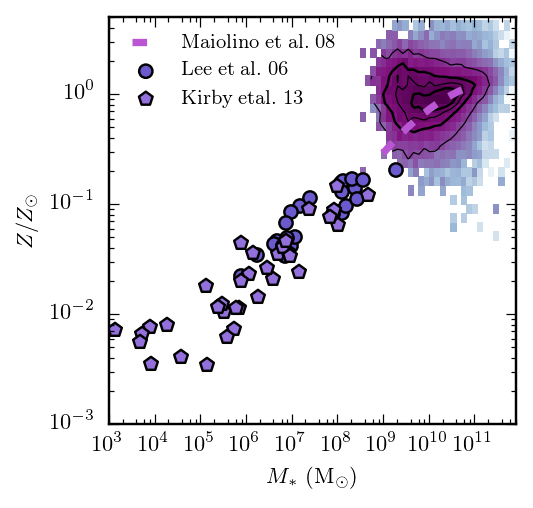

In [61]:
from code.setup import setup

plot_pretty()

fig = plt.figure(figsize=(3, 3))
ylabel = r'$Z/Z_\odot$'; xlabel = r'$M_{*}\ \rm (M_\odot)$'
xlims = [1.e3, 8.e11]; ylims = [1.e-3,  5.]
plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.xscale('log'); plt.yscale('log')
plt.xlim(xlims); plt.ylim(ylims)

#
# plot observational trend from Maiolino
OHsol = 9.
    
def Zmaiolino08(lMs,lM0,K0):
    """
    best fit relation from table in Maiolino et al. 2008 using consistent Z calibration
    """
    return -0.0864*(lMs-lM0)**2 + K0

zcolors = ['mediumorchid', 'red', 'blue', 'darkgray']
zmaio = np.array([0.07,  2.2, 3.5])
lM0 = np.array([11.8, 12.38, 12.76])
K0 = np.array([9.04, 8.99, 8.79])
nzplot = 1

lMs = np.arange(9.0, 11.0, 0.1)
for i, zm in enumerate(zmaio[:nzplot]): 
    Zmaio = Zmaiolino08(lMs, lM0[i], K0[i]) - OHsol + 0.1
    if i == 0:
        plt.plot(10.**lMs, 10.**Zmaio, '--', c=zcolors[i], lw=3.0, label=r'$\rm Maiolino\ et\ al.\ 08$')
    else:
        plt.plot(10.**lMs, 10.**Zmaio, '--', c=zcolors[i], lw=3.0)

#
# plot GAMA data
#

def compute_inverse_Vmax(mags, zs, m_min=None, m_max=None, cosmomodel='WMAP9'):
    """compute inverse Vmax for a given set of galaxy magnitudes and redshifts, given magnitude limits m_min and m_max"""
    #from code.calc_kcor import calc_kcor 
    #ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
    #kcorr = calc_kcor('r', zk, 'g - r', grm)
    from colossus.cosmology import cosmology
    # set cosmology to the best values from 9-year WMAP data
    cosmo = cosmology.setCosmology(cosmomodel)

    # compute luminosity and angular distances
    d_L = cosmo.luminosityDistance(zs)/cosmo.h

    # absolute magnitude in the r-band corrected for extinction
    Mabs = mags - 5.0*np.log10(d_L/1e-5) #- extm + 1.3*zs - kcorr; 

    # the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
    # we need to compute at what distance this galaxy would have limiting magnitude mlim, 
    # then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
    d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mabs))/(1.+zs)
    d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mabs))/(1.+zs)

    vmaxi = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))
    return vmaxi


def plot_GAMA():
    def read_GAMA(fname):
        import pyfits
        hdulist = pyfits.open(fname)
        return np.asarray(hdulist[1].data)
    
    data = read_GAMA(data_home_dir()+"GAMA_AEAtSz.fits")
 
    z_min = 0.061
    z_max = 0.35
    m_min = 10.5
    m_max = 19.1
 
    data = data[data['GAL_MAG_R'] < m_max]; 
    data = data[data['GAL_MAG_R'] > m_min]; 
    data = data[data['Z_HELIO'] > z_min];   
    data = data[data['Z_HELIO'] < z_max]
    data = data[data['EBV'] < 10.0]
 
    vmaxi = compute_inverse_Vmax(data['GAL_MAG_R'], data['Z_HELIO'], m_min, m_max)
    vmaxnorm = np.sum(vmaxi)
    vmaxi /= vmaxnorm
    Z = data['metal']/0.0126 # normalize to solar according to Asplund et al. (2004)
    lZ = np.log10(Z)
    lMstar = data['logmstar']
    Mstar = np.power(10.,lMstar)
    clevs = np.linspace(0.2,0.95,4)
    
    import scipy.optimize as opt
    from matplotlib.colors import LogNorm
 
    def conf_interval(x, pdf, conf_level):
        return np.sum(pdf[pdf > x])-conf_level
 
    #
    H, xbins, ybins = np.histogram2d(lMstar, lZ, weights=vmaxi, bins=(np.linspace(8.5, 12., 31), np.linspace(-1.5, 1.0, 31)))
 
    H = np.rot90(H)
    H = np.flipud(H)
    Hmask = np.ma.masked_where(H==0,H)
    H = H/np.sum(H)        
             
    xbins = 10.**xbins; ybins = 10.**ybins
    X,Y = np.meshgrid(xbins[:-1],ybins[:-1]) 
 
    clevs = np.linspace(0.2,0.95,4)
    lvls = []
    for cld in clevs:  
        sig = opt.brentq( conf_interval, 0., 1., args=(H,cld) )  
        lvls.append(sig)
        
    #plt.scatter(10.**lMstar, 10.**lZ, c='m', s=0.85, alpha=0.5)
    plt.pcolor(X,Y,(Hmask),cmap=plt.cm.BuPu, norm = LogNorm(), label='GAMA',rasterized=True)
    plt.contour(X,Y,(H), linewidths=(1.0,0.5), colors='black', levels = lvls, norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])


plot_GAMA()

# plot Lee et al. 2006
lMsL = np.linspace(5.5, 9.5, 100)
lZLp, elZLp, lMsLp = np.loadtxt(data_home_dir()+"lee06.txt",usecols=(1,3,4),unpack=True)
lZLp = lZLp - OHsol
plt.scatter(10**lMsLp,10.**lZLp, s=30, marker='o', c='slateblue', label=r'$\rm Lee\ et\ al.\ 06$')
lLVk, elLVk, lZk, elZk  = np.loadtxt(data_home_dir()+"kirby13_tab4.txt",usecols=(4,5,6,7),unpack=True)
plt.scatter(10**lLVk, 10.**lZk, s=35, marker='p', c='mediumpurple', label=r'$\rm Kirby\ et al.\ 13$')

plt.legend(frameon=False, loc='upper left', scatterpoints=1, fontsize=8)
#plt.grid()
plt.savefig('fig/MsZ.pdf', bbox_inches='tight')
plt.show()


### Baryonic Tully-Fisher relation

Construct Tully-Fisher (Lr-Vcirc) or baryonic Tully-Fisher $M_*+M_{\rm HI}$-Vcirc using ALFALFA a40 catalog and SDSS DR7 galaxies matched to it. We will use <a href="http://www.physics.upenn.edu/~ameert/SDSS_PhotDec/download/">UPenn catalogs</a> with their model photometry fits to the SDSS DR7 main galaxy sample (<a href="http://adsabs.harvard.edu/abs/2015MNRAS.446.3943M">Meert et al. 2015</a>). We will also use probabilities of morphological classes from Huertas-Company et al. (2011) that are supplied as part of this catalog. 

670722 galaxies in Meert et al. sample initially


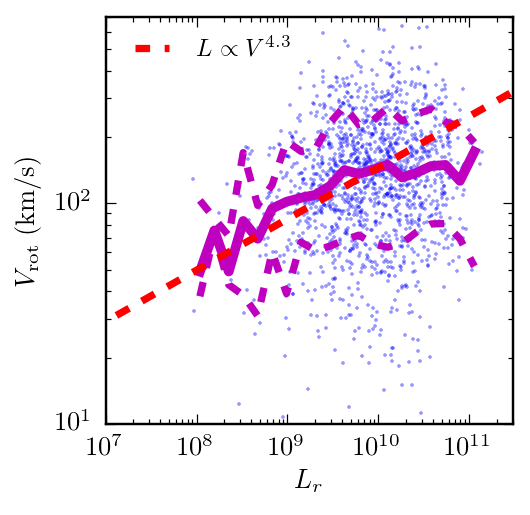

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, stats

from code.read_data import read_alfalfa
from code.read_data import read_alfalfa_sdss_crosslist
from code.read_data import alfalfa_sdss_crossmatch

# read ALFALFA data and SDSS cross-listing table
from code.setup import data_home_dir
aalist   = read_alfalfa(data_home_dir()+'a40.datafile1.txt');
sdsslist = read_alfalfa_sdss_crosslist(data_home_dir()+'a40.datafile3.txt')
# cross-match the catalogs and perform basic cuts
aatf, sdsstf = alfalfa_sdss_crossmatch(aalist, sdsslist)

# read in the relevant data from Meert et al. (2015) catalogs
from code.read_data import read_meert_catalog
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type = 3)

#
# match ALFALFA and SDSS catalogs using photoObjID
#
imatch = np.in1d(sdsstf['PhotoObjID'],sdata['objid'])
imatch2 = np.in1d(sdata['objid'],sdsstf['PhotoObjID'])
aatfmatch = aatf[imatch]; sdssmatch = sdsstf[imatch]
datamatch = sdata[imatch2]; photmatch = phot_r[imatch2]; 
mdatamatch = mdata[imatch2]; mdatagmatch = mdatag[imatch2]; 
mnpdmatch = mnpdata[imatch2]; mnpdgmatch = mnpdatag[imatch2]; 
morphmatch = morph[imatch2]

# import Benedikt Diemer's colossus package
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

# extract relevand data
# redshift and log10(HI mass)
z = sdssmatch['zsdss']; lMHI = aatfmatch['logMsun']
# compute luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(z)/cosmo.h

extm = mnpdmatch['extinction']; kcorr = mnpdmatch['kcorr']
# abs. magnitude from the Meert et al. photometry using fit specified by phot_type above
# corrected for extinction, evolution, and k-correction
Mr = mdatamatch['m_tot'] - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*z - kcorr;
gr = mdatagmatch['m_tot'] - mdatamatch['m_tot']  - mnpdgmatch['extinction'] + mnpdmatch['extinction']
ur = sdssmatch['uminusr']
ba = mdatamatch['ba_tot']
cos2 = (np.power(ba,2)-0.13*0.13)/(1.0-0.13*0.13)
sini = np.sqrt(1.0-cos2)
# convert line width into rotation velocity (ostensibly)
s = 0.5*aatfmatch['W50']/sini

#
# assigned probability for galaxy to be of particular type from Huertas-Company et al. 2011 classification
#
pSab = morphmatch['probaSab']; pScd = morphmatch['probaScd']; pS0  = morphmatch['probaS0']

# maximize disks, get rid of likely S0's
pdisk = 0.7
indplot = (((pSab > pdisk) | (pScd > pdisk)) & (pS0<0.3))
Mr = Mr[indplot]; s = s[indplot]; lMHI = lMHI[indplot]
ur = ur[indplot]; gr = gr[indplot]
Lr = np.power(10.,-0.4*(Mr-4.68))
addHI = False
if addHI:
    # get the  r-band M/L ratio from color using 
    # linear mapping from (u-r) or (g-r) color from Table 7 of 
    # Bell et al. 2003, ApJS 149, 289 derived from SPS 
    #lMLr = -0.223 + 0.299*ur
    lMLr = -0.306 + 1.097*gr
    # convert Lr to stellar mass, add HI 
    Lr = np.clip(lMLr*Lr,1.e3,1.e15) + np.power(10.,lMHI)

# now plot the relation
#
fig = plt.figure(figsize=(3, 3))
plt.rc('font',size=11)

if addHI:
    plt.xlabel(r'$M_*+M_{\mathrm{HI}}\ (M_{\odot})$')
else:
    plt.xlabel(r'$L_r$')
plt.ylabel(r'$V_{\rm rot}\ (\mathrm{km/s})$')
plt.ylim(10.,700.); 
plt.xlim(1.e7, 3.e11);
plt.yscale('log'); plt.xscale('log')

from scipy.stats import binned_statistic
cmed, ibedges, NMbins = binned_statistic(np.log10(Lr),s,statistic='median',bins=20)

ibins = 0.5*(ibedges[1:] + ibedges[:-1])

plt.scatter(Lr, s, marker='.', color='blue', s=0.75, alpha=0.5)
plt.plot(10.**ibins,cmed,c='m',lw=4.0)

def perc84(x):
    return np.percentile(x,84.0)
def perc16(x):
    return np.percentile(x,16.0)
    
s16, ibedges, NMbins = binned_statistic(np.log10(Lr),s,statistic=perc16,bins=20)
s84, ibedges, NMbins = binned_statistic(np.log10(Lr),s,statistic=perc84,bins=20)
plt.plot(10.**ibins, s16,'--',c='m',lw=3.0)
plt.plot(10.**ibins, s84,'--',c='m',lw=3.0)

# plot the L~Vmax^a power law appropriate for a given relation
x = np.linspace(6., 12., 100)
if not addHI:
    y = 85.*10**((x-9.)/4.3); plabel = '$L\propto V^{4.3}$'
else:
    y = 65.*10**((x-9.)/3.3); plabel = '$M_*+M_{\mathrm{HI}}\propto V^{3.3}$'

plt.plot(10.**x,y,'--', c='r', lw=3.0, label=plabel)

plt.legend(frameon=False, fontsize=10, loc='upper left')
plt.show()
